<a href="https://www.kaggle.com/code/umangmaurya03/traintest?scriptVersionId=149720307" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Importing The Libraries

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading Data

In [2]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')

## Viewing Data

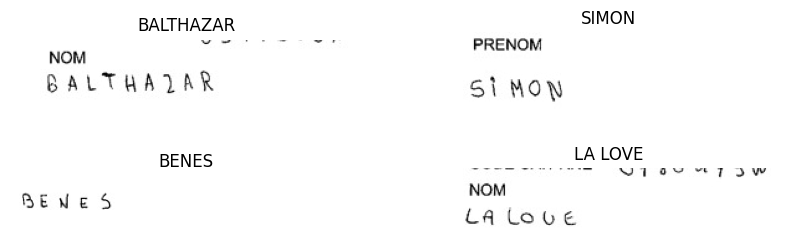

In [3]:
plt.figure(figsize=(10, 10))

for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

In [4]:
# NaN in the labels
print("Number of NaNs in train set      : ", train['IDENTITY'].isna().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isna().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [5]:
# Dropping the NaNs
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

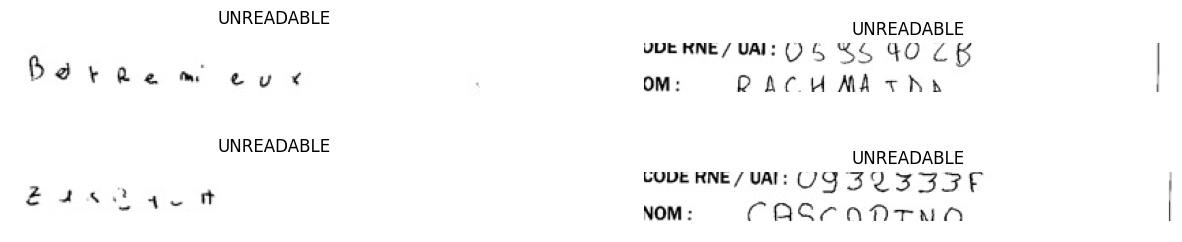

In [6]:
# Some of the images have label 'UNREADABLE'
unread = train[train['IDENTITY'] == 'UNREADABLE']
unread.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unread.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unread.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [7]:
# Removing the Unreadable
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [8]:
# Coverting lowercase to uppercase
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [9]:
# Resetting the index
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

## Preprocessing the images

## Preprocessing Function

In this code snippet, we define a Python function called `preprocess(img)` that is designed to preprocess images for further use in project. The primary purpose of this function is to resize and format the input image to a consistent size and orientation.

Here's a breakdown of what this function does:

1. **Input Parameters**: The function takes an image (`img`) as input, which is expected to be a NumPy array representing an image.

2. **Image Dimensions**: The function first extracts the height (`h`) and width (`w`) of the input image using the `shape` attribute.

3. **Creating a Blank Image**: It initializes a blank white image with dimensions of 64 pixels in height and 256 pixels in width. This new image is stored in the variable `final_img`. This step ensures that all preprocessed images will have the same size.

4. **Cropping**: The code includes logic to crop the input image (`img`) if its dimensions exceed the desired 64x256 size. If the height (`h`) of the image is greater than 64 pixels, it crops the top part of the image to 64 pixels. Similarly, if the width (`w`) of the image is greater than 256 pixels, it crops the right side of the image to 256 pixels.

5. **Image Copy**: The cropped portion of the input image is then copied onto the blank `final_img` to create a properly sized and centered image.

6. **Rotation**: The final image is rotated 90 degrees clockwise using OpenCV's `cv2.rotate` function. This step ensures that the images are consistently oriented, which can be important for various computer vision tasks.

7. **Output**: The preprocessed image is returned by the function.


In [10]:
# Fuction to preprocess the img
def preprocess(img):
    (h, w) = img.shape                                    # Getting the height & width of the image
    
    final_img = np.ones([64, 256])*255                    # Blank white image
    
    # crop    
    if h > 64:
        img = img[:64, :]                                 # If the h>64 then it is cropped to 64
        
    if w > 256:
        img = img[:, :256]                                # If the w>256 then it is cropped to 256
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE) # Rotate 90° Clockwise & return

Model would be train on 20000 images and validate on 2000 images

In [11]:
train_size = 17600
valid_size = 4400

In [12]:
train_x = []                                                # Initialize a list to store preprocessed images

for i in range(train_size):                                 # Loop through the training dataset
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)       # Read the image in grayscale
    image = preprocess(image)                               # Apply image preprocessing
    image = image / 255.0                                   # Normalize pixel values to [0, 1]
    train_x.append(image)
    
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1} images")

print("Processing complete.")

Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images
Processed 11000 images
Processed 12000 images
Processed 13000 images
Processed 14000 images
Processed 15000 images
Processed 16000 images
Processed 17000 images
Processing complete.


In [13]:
valid_x = []

for i in range(valid_size):                                  # Loop through the validation dataset
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/' + valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)        # Read the image in grayscale
    image = preprocess(image)                                # Apply image preprocessing
    image = image / 255.0                                    # Normalize pixel values to [0, 1]
    valid_x.append(image)

    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1} validation images")

print("Validation processing complete.")


Processed 1000 validation images
Processed 2000 validation images
Processed 3000 validation images
Processed 4000 validation images
Validation processing complete.


In [14]:
# Convert 'train_x' to a NumPy array and reshape it
train_x = np.array(train_x).reshape(-1, 256, 64, 1)

# Convert 'valid_x' to a NumPy array and reshape it
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)


## Label to  Num & Num to Label
### For CTC loss

## Data Label Preprocessing

In this section of the code, we perform data label preprocessing for a text recognition task. The goal is to convert text labels into a numerical format for use in training a neural network. Let's break down the key components of this preprocessing:

### Character Set and Constants
- `alphabets`: This string represents the set of valid characters that can appear in the text labels. It includes uppercase letters, hyphen, and space.

- `max_str_len`: This constant defines the maximum length of the input labels.

- `num_of_characters`: The number of unique characters, including an extra one for the CTC pseudo-blank character.

- `num_of_timestamps`: The maximum length of predicted labels.

### Label-to-Number Conversion
- `label_to_num(label)`: This function converts a text label to a numerical representation. It initializes an empty list to store character indices and iterates over each character in the input label. For each character, it finds the index in the `alphabets` string and appends it to the list. The function returns a NumPy array with the numerical representation of the label.

### Number-to-Label Conversion
- `num_to_label(num)`: This function converts a list of numerical values back to a text label. It iterates over each character index in the input list, checks for the CTC blank character (-1), and appends the corresponding character from `alphabets` to the output string.

### Initialization of Arrays
Several arrays are initialized to store the preprocessed labels and related information for both training and validation datasets. These include:
- `train_y`: An array to store the converted labels for the training dataset.

- `train_label_len`: An array to store the length of labels for each data point in the training dataset.

- `train_input_len`: An array to store the input length for each data point in the training dataset.

- `train_output`: An array to store training data outputs (usually used for CTC loss).

### Data Processing
A loop is used to process both the training and validation datasets. Within the loop:
- The 'IDENTITY' value from the dataset is retrieved and converted to a string if it's not already.

- The label length is set and label values are stored in the corresponding arrays (`train_y` for training and `valid_y` for validation).



In [15]:
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "  # The set of valid characters
max_str_len = 24                             # Maximum length of input labels
num_of_characters = len(alphabets) + 1       # Number of unique characters, plus 1 for CTC pseudo-blank
num_of_timestamps = 64                       # Maximum length of predicted labels

In [16]:
def label_to_num(label):
    label_num = []                            # Initialize an empty list to store character indices
    for ch in label:                          # Iterate over each character in the input label
        label_num.append(alphabets.find(ch))  # Find the index of the character in the 'alphabets' string
        
    return np.array(label_num)                # Convert the list to a NumPy array and return it

In [17]:
def num_to_label(num):
    ret = ""                                  # Initialize an empty string to store the label
    for ch in num:                             # Iterate over each character index in the input list
        if ch == -1:                           # Check for the CTC Blank (a special case)
            break
        else:
            ret += alphabets[ch]               # Append the character from 'alphabets' based on the index
    return ret

In [18]:
name = 'UMANG'
print(name, '\n',label_to_num(name))

UMANG 
 [20 12  0 13  6]


In [19]:
blank_label = -1

In [20]:
# Initialize arrays
train_y = np.ones([train_size, max_str_len]) * blank_label
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps - 2)
train_output = np.zeros([train_size])

# Loop through the training data
for i in range(train_size):
    # Get the 'IDENTITY' value and convert it to a string if it's not already
    identity = train.loc[i, 'IDENTITY']
    if not isinstance(identity, str):
        identity = str(identity)
    
    # Set the label length and label values in train_y
    train_label_len[i] = len(identity)
    
    # Assuming label_to_num is a function that converts characters to numerical values
    train_y[i, 0:len(identity)] = label_to_num(identity)


In [21]:
# Initialize arrays for validation data
valid_y = np.ones([valid_size, max_str_len]) * blank_label
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps - 2)
valid_output = np.zeros([valid_size])

# Loop through the validation data
for i in range(valid_size):
    # Get the 'IDENTITY' value and convert it to a string if it's not already
    identity = valid.loc[i, 'IDENTITY']
    if not isinstance(identity, str):
        identity = str(identity)
    
    # Set the label length and label values in valid_y
    valid_label_len[i] = len(identity)
    
    # Assuming label_to_num is a function that converts characters to numerical values
    valid_y[i, 0:len(identity)] = label_to_num(identity)

In [22]:
print('True label : ',train.loc[4, 'IDENTITY'] , '\ntrain_y : ',train_y[4],'\ntrain_label_len : ',train_label_len[4], 
      '\ntrain_input_len : ', train_input_len[4])

True label :  DAPHNE 
train_y :  [ 3.  0. 15.  7. 13.  4. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [6.] 
train_input_len :  [62.]


## Building The Model

## Convolutional Recurrent Neural Network (CRNN) Architecture

In this code snippet, we define a Convolutional Recurrent Neural Network (CRNN) model for processing grayscale images with a shape of (256, 64, 1). This architecture combines both convolutional and recurrent layers, making it suitable for various tasks, such as text recognition in images.

Let's break down the components of this model:

### Input Layer
The model starts with an input layer that is designed to accept grayscale images with dimensions of 256x64 pixels.

### Convolutional Layers
1. **Convolutional Layer 1**: This layer applies 32 filters with a (3, 3) kernel, 'same' padding, and He normal initialization. It is followed by batch normalization, ReLU activation, and max-pooling with a (2, 2) pool size.

2. **Convolutional Layer 2**: Similar to the first layer, but with 64 filters.

3. **Convolutional Layer 3**: This layer has 128 filters, followed by batch normalization, ReLU activation, and max-pooling with a (1, 2) pool size. Dropout with a rate of 0.3 is also applied.

### Reshape Layer
After the convolutional layers, the output is reshaped to have a target shape of (64, 1024). This reshaped output is then fed into the recurrent layers.

### Fully Connected Layer
A fully connected layer with 64 units and ReLU activation is applied to the reshaped output.

### Bidirectional LSTM Layers
Two bidirectional Long Short-Term Memory (LSTM) layers with 256 units each are used. These layers return sequences and are essential for handling sequential data, making them suitable for tasks like text recognition.

### Output Layer
The output layer consists of a dense layer with the number of characters as the output units. The softmax activation function is applied to produce probabilities for each character in the output sequence.

### Model Creation
The model is created using the Keras Functional API, with the input and output layers specified.

### Model Summary
Finally, the code provides a summary of the model architecture, displaying the layers, their shapes, and the number of parameters.


In [23]:
# Define the input layer with a shape of (256, 64, 1) for grayscale images
input_data = Input(shape=(256, 64, 1), name='input')

# Convolutional Layer 1: 32 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)                         # Batch normalization
inner = Activation('relu')(inner)                           # ReLU activation
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # Max-pooling

# Convolutional Layer 2: 64 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)  
inner = Activation('relu')(inner)     
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  
inner = Dropout(0.3)(inner)                                 

# Convolutional Layer 3: 128 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)                         
inner = Activation('relu')(inner)                           
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  
inner = Dropout(0.3)(inner)                                 

# Reshape the output for sequence processing
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)

# Fully Connected Layer 1: 64 units, ReLU activation, He normal initialization
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# Bidirectional LSTM Layers: 256 units, return sequences
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# Output Layer: Number of characters, He normal initialization
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)  # Softmax activation

# Create the model with input and output layers
model = Model(inputs=input_data, outputs=y_pred)

# Display a summary of the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

Compute the CTC loss between predicted and true labels.

    Args:
        args (tuple): A tuple containing four elements: y_pred (predicted output sequence),
                      labels (true label sequence), input_length (length of input sequence),
                      and label_length (length of true label sequence).

    Returns:
        tensor: The CTC loss.

In [24]:
# The ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # The 2 is critical here since the first couple outputs of the RNN tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [25]:
# Define input placeholders for true labels, input sequence length, and label sequence length
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Calculate CTC loss using the ctc_lambda_func function
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# Create the final model that takes input data, true labels, input length, and label length
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)


## Training the Model

In [26]:
# Compile the final model with a dummy loss lambda function (loss calculation occurs elsewhere)
# The optimizer used is Adam with a learning rate of 0.0001
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0001))

# Fit the model using training and validation data
model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],                                # Input data and placeholders
    y=train_output,                                                                        # True output labels
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
    epochs=60,                                                                             # Number of training epochs
    batch_size=128                                                                         # Batch size for training
)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/60


2023-11-07 14:38:30.558395: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


138/138 [==============================] - 40s 195ms/step - loss: 30.5612 - val_loss: 23.4276
Epoch 2/60
138/138 [==============================] - 24s 177ms/step - loss: 20.4534 - val_loss: 20.4628
Epoch 3/60
138/138 [==============================] - 24s 176ms/step - loss: 20.1770 - val_loss: 20.2032
Epoch 4/60
138/138 [==============================] - 24s 177ms/step - loss: 19.9883 - val_loss: 19.9821
Epoch 5/60
138/138 [==============================] - 24s 176ms/step - loss: 19.7776 - val_loss: 19.7616
Epoch 6/60
138/138 [==============================] - 24s 177ms/step - loss: 19.5571 - val_loss: 19.4464
Epoch 7/60
138/138 [==============================] - 24s 176ms/step - loss: 19.1147 - val_loss: 18.7175
Epoch 8/60
138/138 [==============================] - 24s 177ms/step - loss: 18.3042 - val_loss: 18.1765
Epoch 9/60
138/138 [==============================] - 24s 177ms/step - loss: 17.3577 - val_loss: 17.1709
Epoch 10/60
138/138 [==============================] - 24s 176ms/s

In [27]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

138/138 [==============================] - 4s 15ms/step


In [28]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 83.24%
Correct words predicted      : 66.41%


## Prediction on Test Set

1/1 [==============================] - 0s 23ms/step


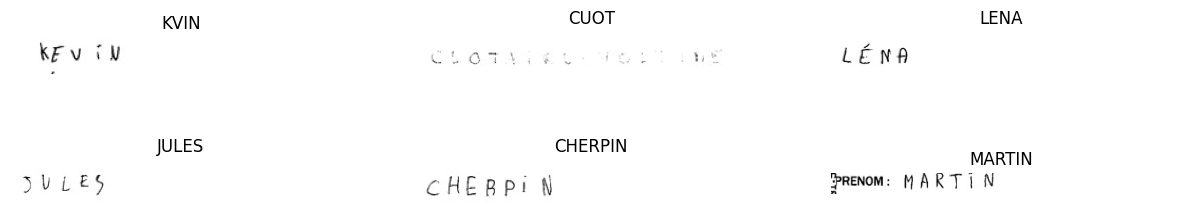

In [29]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [30]:
# Initialize variables to track correct characters
correct_characters = 0
total_characters = 0
max_images = 100  # Specify the number of images to evaluate

# Iterate through the test set
for i in range(min(len(test), max_images)):
    # Get the ground truth label
    ground_truth = test.loc[i, 'IDENTITY']
    
    # Preprocess and predict the image using your model
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/' + test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image / 255.0
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
    predicted_label = num_to_label(decoded[0])

    # Calculate character-level accuracy
    for j in range(min(len(ground_truth), len(predicted_label))):
        if ground_truth[j] == predicted_label[j]:
            correct_characters += 1
        total_characters += 1

# Calculate character-level accuracy
character_level_accuracy = (correct_characters / total_characters) * 100



1/1 [==============================] - 0s 25ms/step


In [31]:
print('Character-Level Accuracy for {} images: {:.2f}%'.format(max_images, character_level_accuracy))

Character-Level Accuracy for 100 images: 80.79%


In [32]:
def predict(index):
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/' + test.loc[index, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image / 255.

    # Reshape the image to have a batch size of 1
    image = image.reshape(1, 256, 64, 1)

    pred = model.predict(image)
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)[0][0])

    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 27ms/step


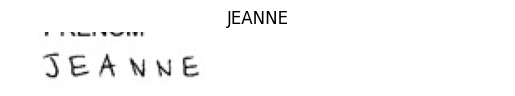

In [33]:
predict(10261)